# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.1+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 20
BATCH_SIZE: int = 32

In [4]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


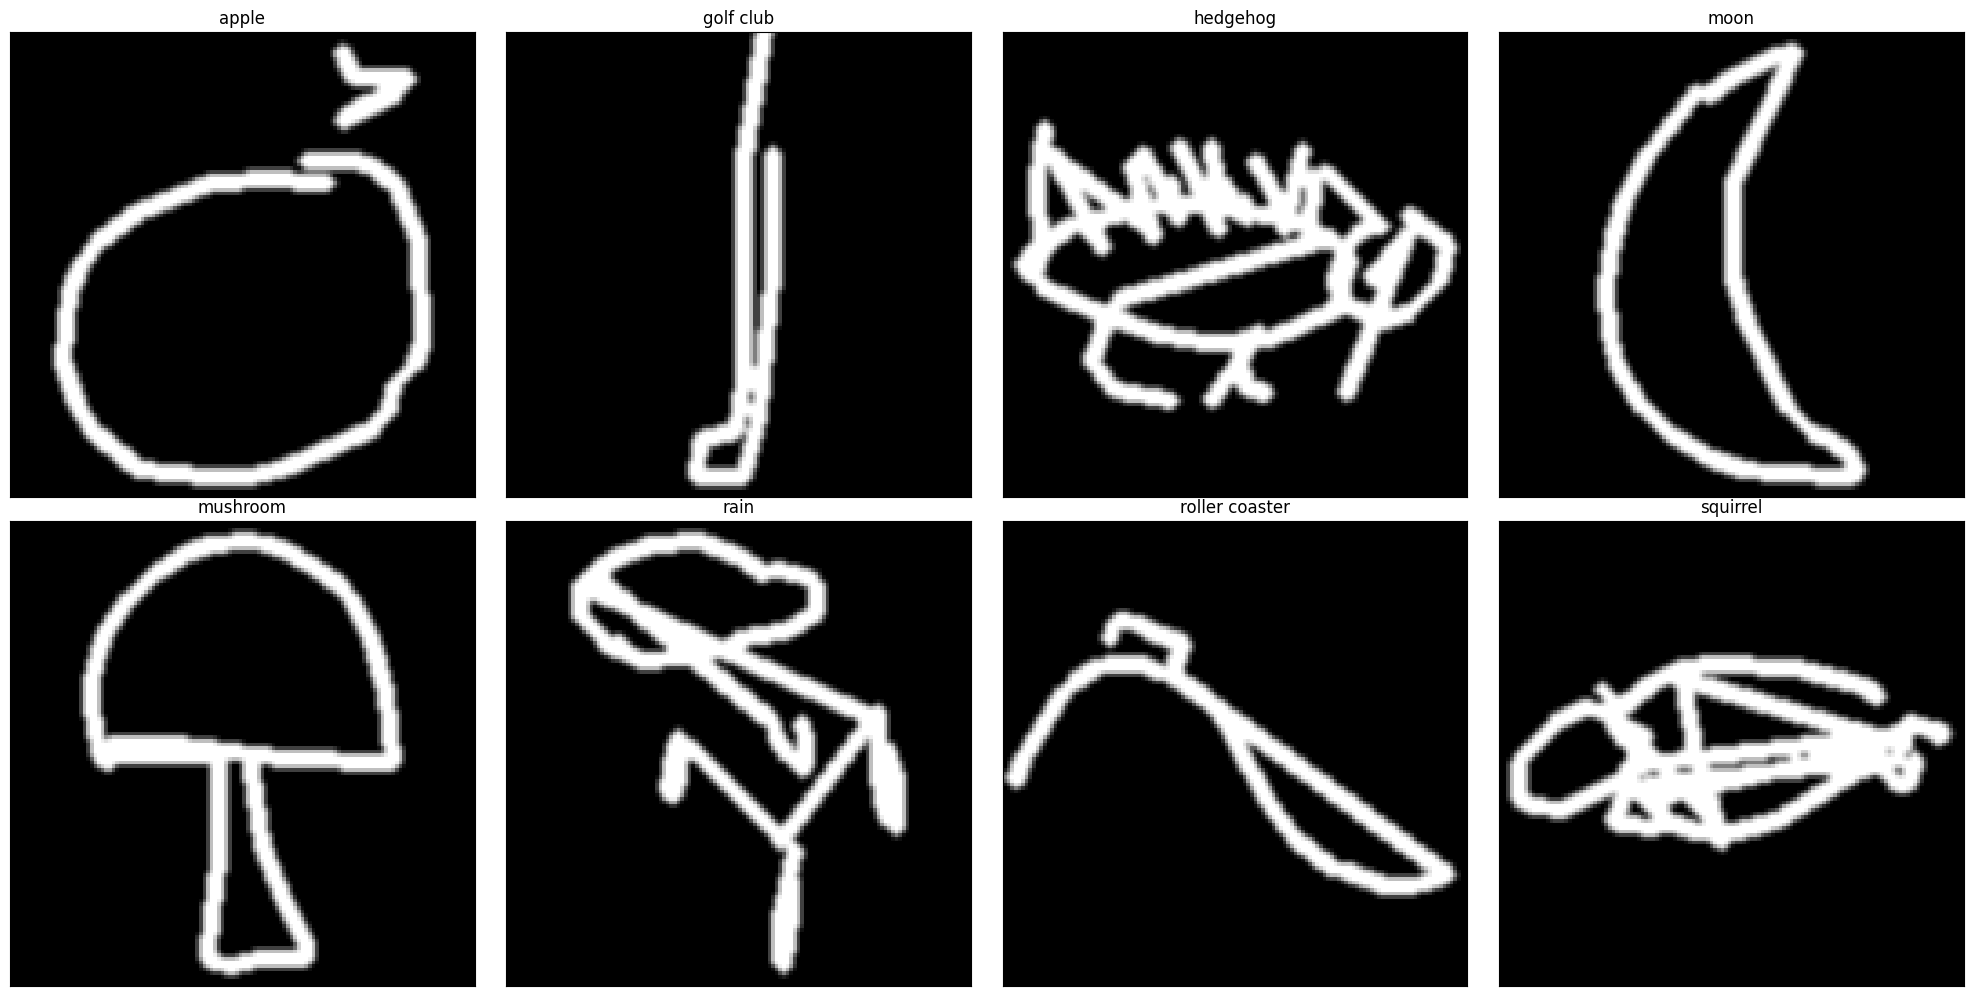

In [5]:
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(nb_classes):
    index = random.randint(0, class_size[classes[i]])
    ax = axes[i//numb_cols, i%numb_cols]
    ax.imshow(ImageCreation.createImage(data[i]["train"][index], (WIDTH, HEIGHT), STROKE_SIZE, IMAGE_FACTOR), cmap='gray')
    ax.set_title(classes[i])

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

print(type(training_labels))
print(type(shuffled_training_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 30
valid_test_subset = 10

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

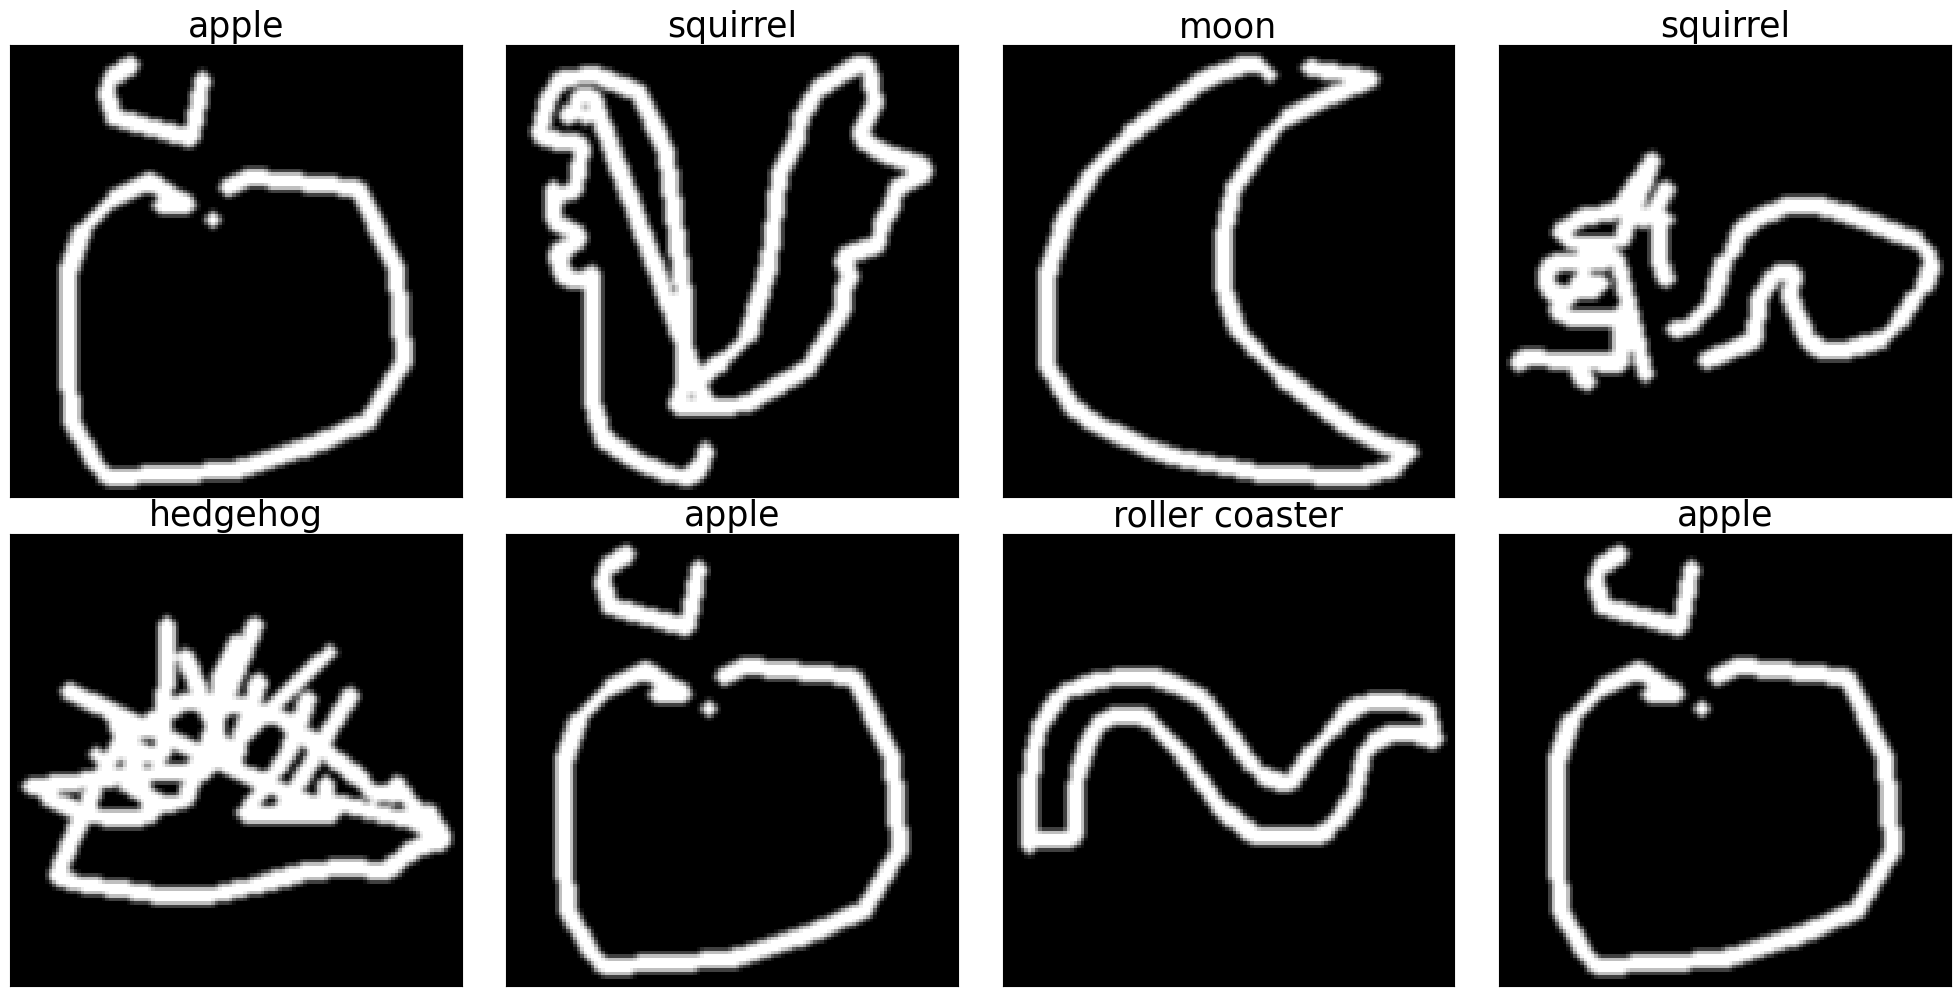

In [9]:
# Show some images
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(numb_rows*numb_cols):
    index = random.randint(0, len(training_set))
    ax = axes[i//numb_cols, i%numb_cols]

    img, label_index = training_set[index]

    ax.imshow(training_set.convert_to_img(img), cmap='gray')
    ax.set_title(classes[label_index], fontsize=25)

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## Autoencoder class

In [10]:
from src.autoencoder import Autoencoder

## Try with simple model

In [11]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 3]
autoencoder_model = Autoencoder(architecture_1, device, WIDTH, HEIGHT, classes)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.1)

In [12]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=16384, out_features=5461, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=5461, out_features=16384, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.000183116645303


In [13]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def tensor_to_img(tensor):
    return tensor_to_numpy(tensor).reshape((WIDTH, HEIGHT))

In [14]:
# Call the function
num_epochs = 40
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.2297	Test Loss 0.8453	Train PSNR: 0.8230	Train SSIM: 0.0297	Validation PSNR: 0.7412	Validation SSIM: 0.0339
Epoch [2/40]	Loss: 0.8293	Test Loss 0.8452	Train PSNR: 0.8233	Train SSIM: 0.0296	Validation PSNR: 0.7416	Validation SSIM: 0.0339
Epoch [3/40]	Loss: 0.8293	Test Loss 0.8453	Train PSNR: 0.8233	Train SSIM: 0.0296	Validation PSNR: 0.7415	Validation SSIM: 0.0339
Epoch [4/40]	Loss: 0.8293	Test Loss 0.8453	Train PSNR: 0.8236	Train SSIM: 0.0298	Validation PSNR: 0.7415	Validation SSIM: 0.0339
Epoch [5/40]	Loss: 0.8292	Test Loss 0.8452	Train PSNR: 0.8237	Train SSIM: 0.0299	Validation PSNR: 0.7415	Validation SSIM: 0.0340
Epoch [6/40]	Loss: 0.8292	Test Loss 0.8452	Train PSNR: 0.8236	Train SSIM: 0.0299	Validation PSNR: 0.7416	Validation SSIM: 0.0340
Epoch [7/40]	Loss: 0.8292	Test Loss 0.8453	Train PSNR: 0.8236	Train SSIM: 0.0299	Validation PSNR: 0.7415	Validation SSIM: 0.0339
Epoch [8/40]	Loss: 0.8292	Test Loss 0.8453	Train PSNR: 0.8236	Train SSIM: 0.0299	Validation PSNR:

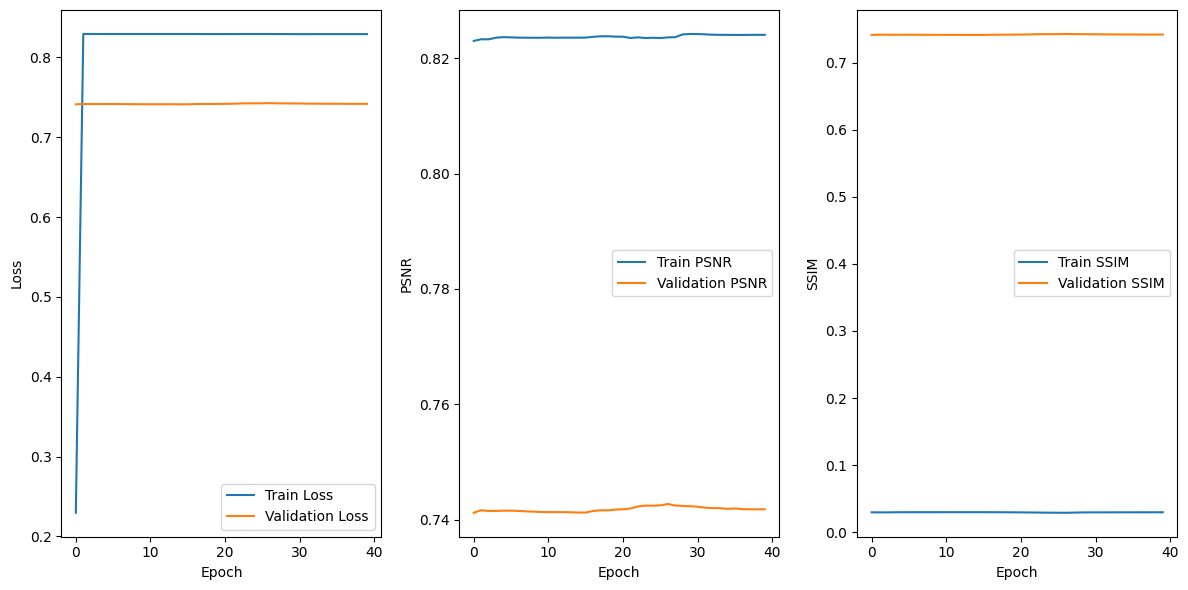

In [15]:
autoencoder_model.plot_psnr_ssim()

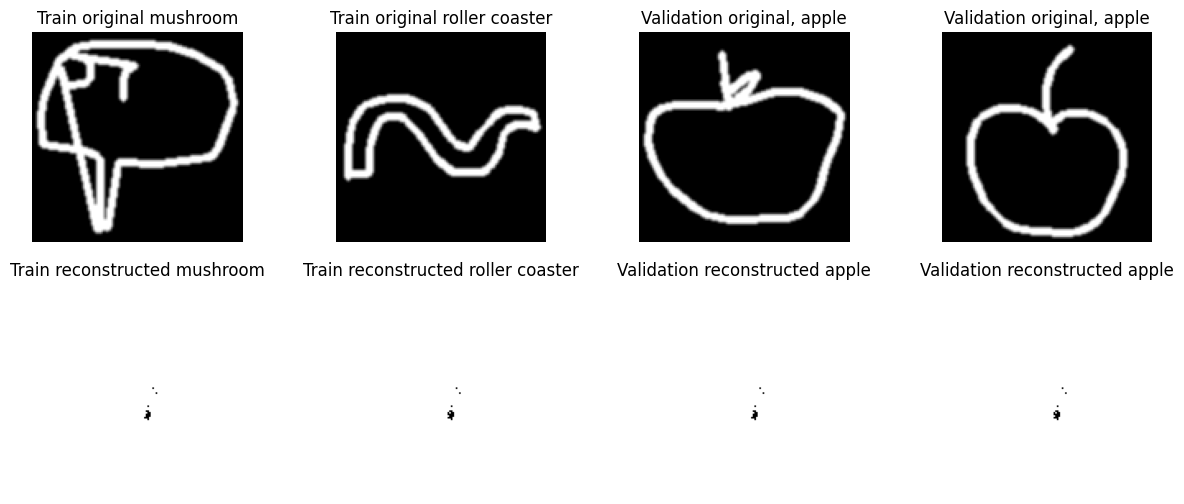

In [16]:
autoencoder_model.show_images(training_set, validation_set)

In [17]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [18]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 9|0.2894580538064475, Lowest SSIM index: 9|0.007134291554057504


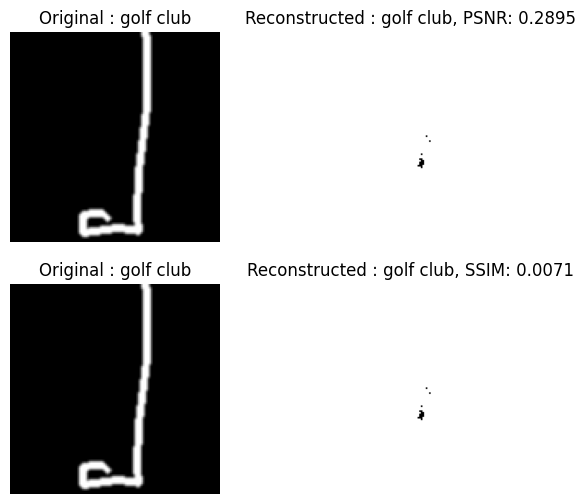

In [19]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [20]:
layers = [WIDTH * HEIGHT, WIDTH * HEIGHT]
autocoder_2 = Autoencoder(layers, device, WIDTH, HEIGHT, classes)
autocoder_2.to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / autocoder_2.architecture[-1]}')

Sequential(
  (encoder_0): Linear(in_features=16384, out_features=16384, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=16384, out_features=16384, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 1.0


In [21]:
num_epochs = 40

autocoder_2.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.2296	Test Loss 0.1684	Train PSNR: 8.7498	Train SSIM: 0.0408	Validation PSNR: 7.7495	Validation SSIM: 0.0047
Epoch [2/40]	Loss: 0.1340	Test Loss 0.1497	Train PSNR: 8.4305	Train SSIM: 0.5093	Validation PSNR: 8.3839	Validation SSIM: 0.4894
Epoch [3/40]	Loss: 0.1466	Test Loss 0.1496	Train PSNR: 8.2692	Train SSIM: 0.5281	Validation PSNR: 8.4073	Validation SSIM: 0.5328
Epoch [4/40]	Loss: 0.1529	Test Loss 0.1361	Train PSNR: 8.6306	Train SSIM: 0.5976	Validation PSNR: 8.8711	Validation SSIM: 0.6123
Epoch [5/40]	Loss: 0.1421	Test Loss 0.1307	Train PSNR: 8.7670	Train SSIM: 0.6269	Validation PSNR: 9.0836	Validation SSIM: 0.6477
Epoch [6/40]	Loss: 0.1385	Test Loss 0.1284	Train PSNR: 8.8214	Train SSIM: 0.6377	Validation PSNR: 9.1794	Validation SSIM: 0.6622
Epoch [7/40]	Loss: 0.1370	Test Loss 0.1263	Train PSNR: 8.8742	Train SSIM: 0.6463	Validation PSNR: 9.2673	Validation SSIM: 0.6734
Epoch [8/40]	Loss: 0.1357	Test Loss 0.1249	Train PSNR: 8.9054	Train SSIM: 0.6522	Validation PSNR:

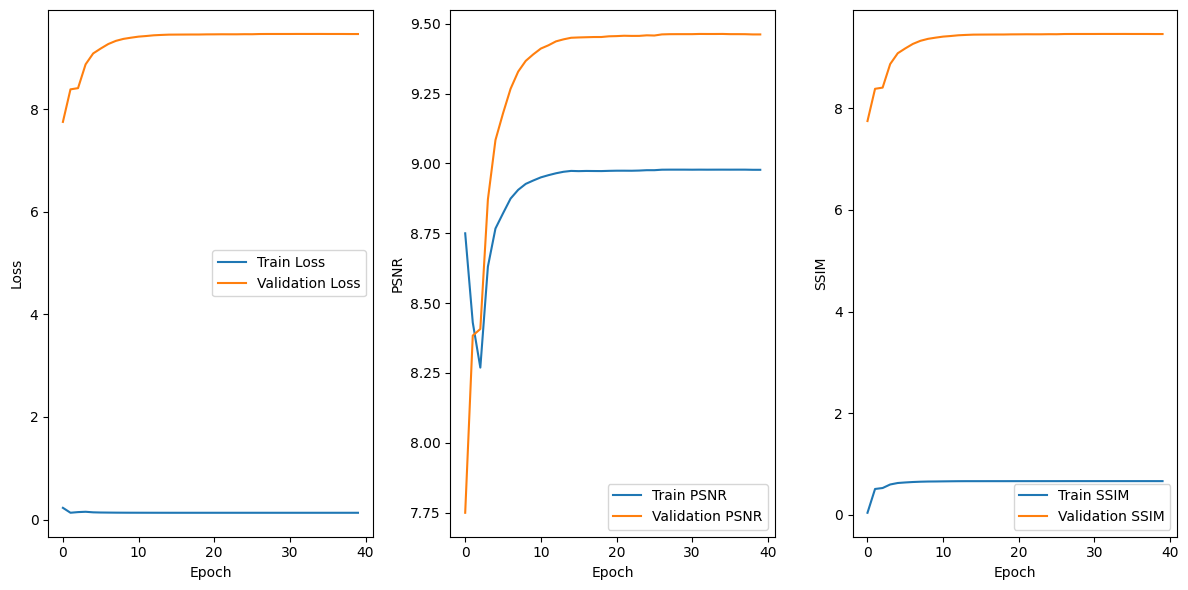

In [22]:
autocoder_2.plot_psnr_ssim()

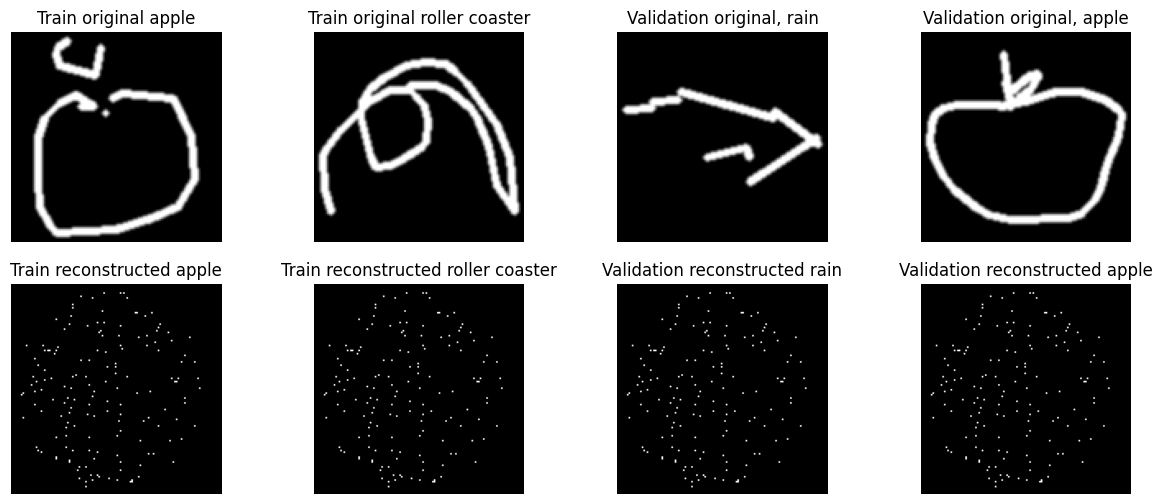

In [23]:
autocoder_2.show_images(training_set, validation_set)

Lowest PSNR index: 7|7.0135155864187535, Lowest SSIM index: 7|0.5415341533695118


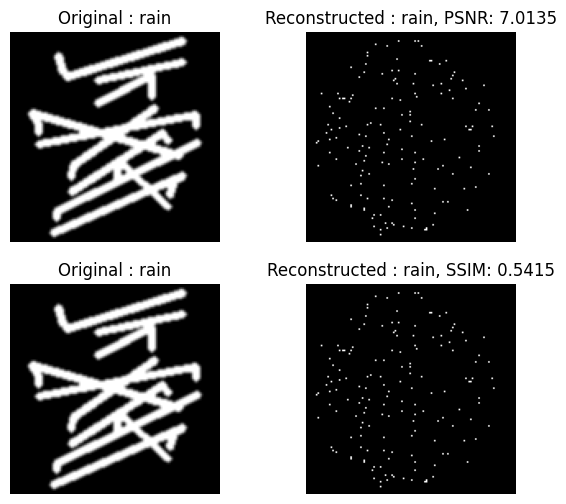

In [24]:
lowest_psnr, lowest_ssim = autocoder_2.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

autocoder_2.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Try with resnet18 architecture

In [25]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/nprzybylski/Cours/project/env_SR/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nprzybylski/Cours/project/env_SR/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# Define a function to train the model
def train_pretained_model():
    pass

## Generating images

In [27]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]

        count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [28]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

Class apple range of mean encoded vector: [-inf, inf]
Class golf club range of mean encoded vector: [-inf, inf]
Class hedgehog range of mean encoded vector: [-inf, inf]
Class moon range of mean encoded vector: [-24.651321710324755, 24.588890644148286]
Class mushroom range of mean encoded vector: [-inf, inf]
Class rain range of mean encoded vector: [-inf, inf]
Class roller coaster range of mean encoded vector: [-inf, inf]
Class squirrel range of mean encoded vector: [-inf, inf]


/tmp/ipykernel_15185/846146186.py:22: RuntimeWarning: divide by zero encountered in divide
  mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0


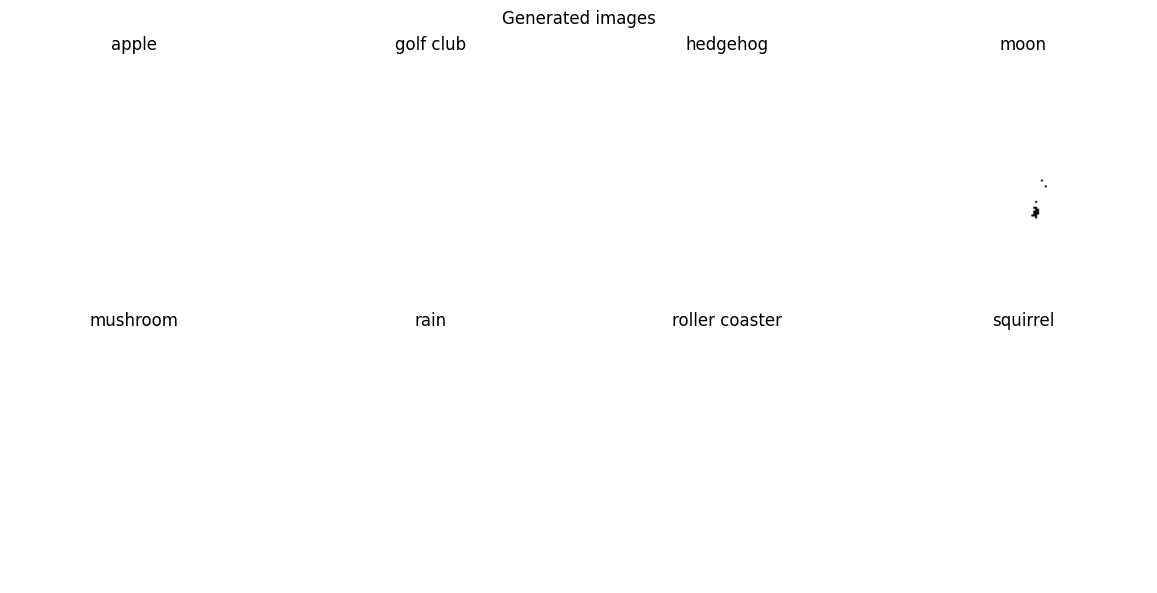

In [29]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

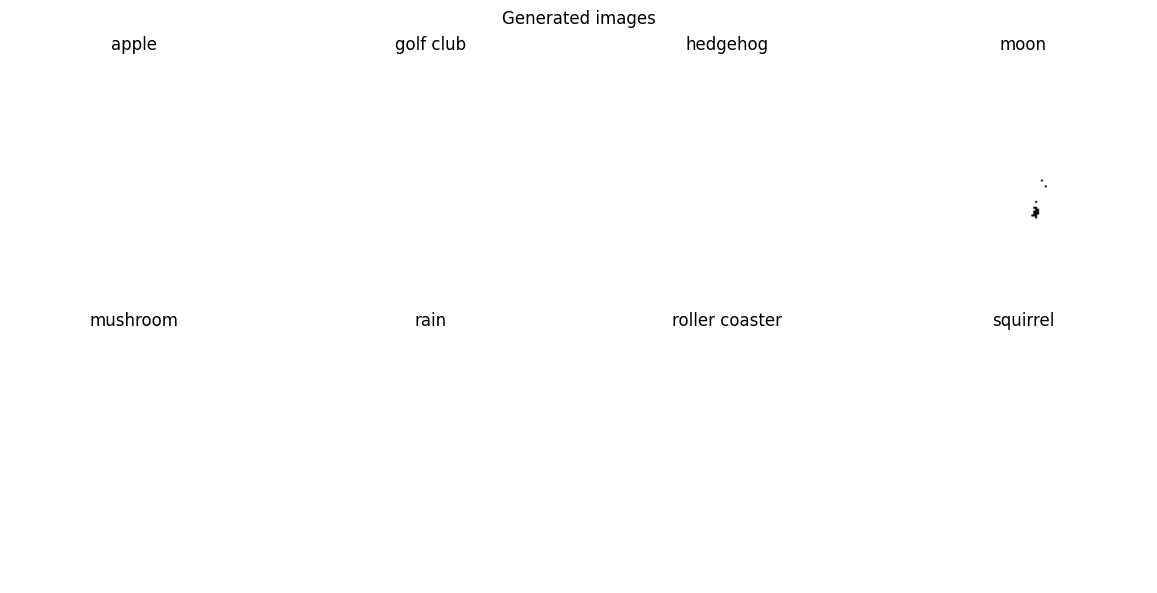

In [30]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)

/tmp/ipykernel_15185/846146186.py:22: RuntimeWarning: divide by zero encountered in divide
  mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0


Class apple range of mean encoded vector: [-inf, inf]
Class golf club range of mean encoded vector: [-inf, inf]
Class hedgehog range of mean encoded vector: [-inf, inf]
Class moon range of mean encoded vector: [-inf, inf]
Class mushroom range of mean encoded vector: [-16.47236519607843, 16.459599992340685]
Class rain range of mean encoded vector: [-inf, inf]
Class roller coaster range of mean encoded vector: [-inf, inf]
Class squirrel range of mean encoded vector: [-inf, inf]


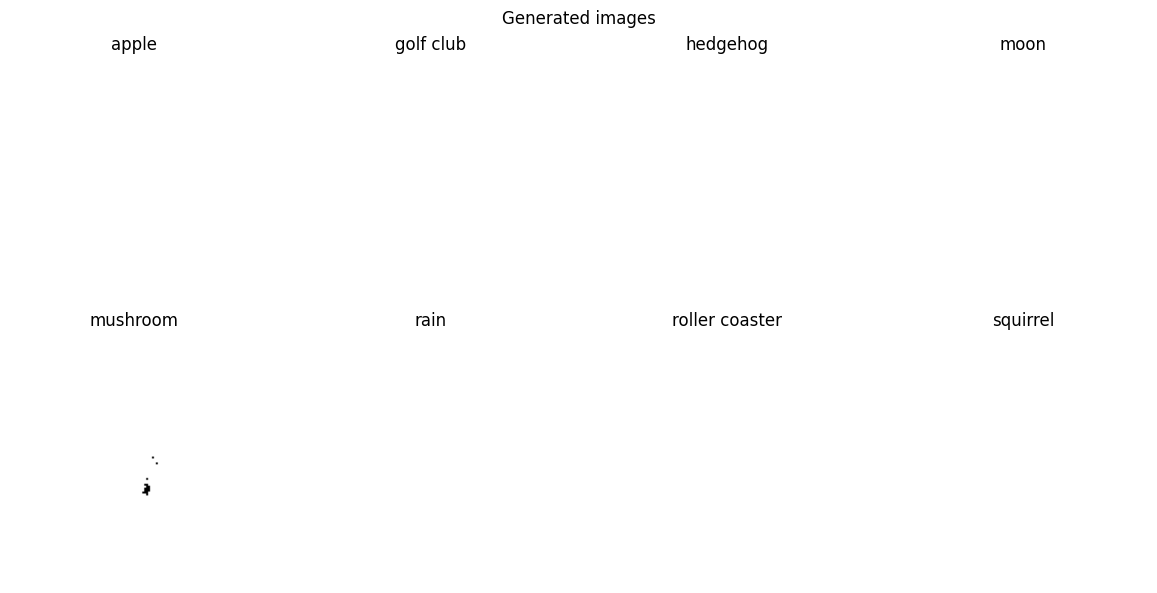

In [31]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

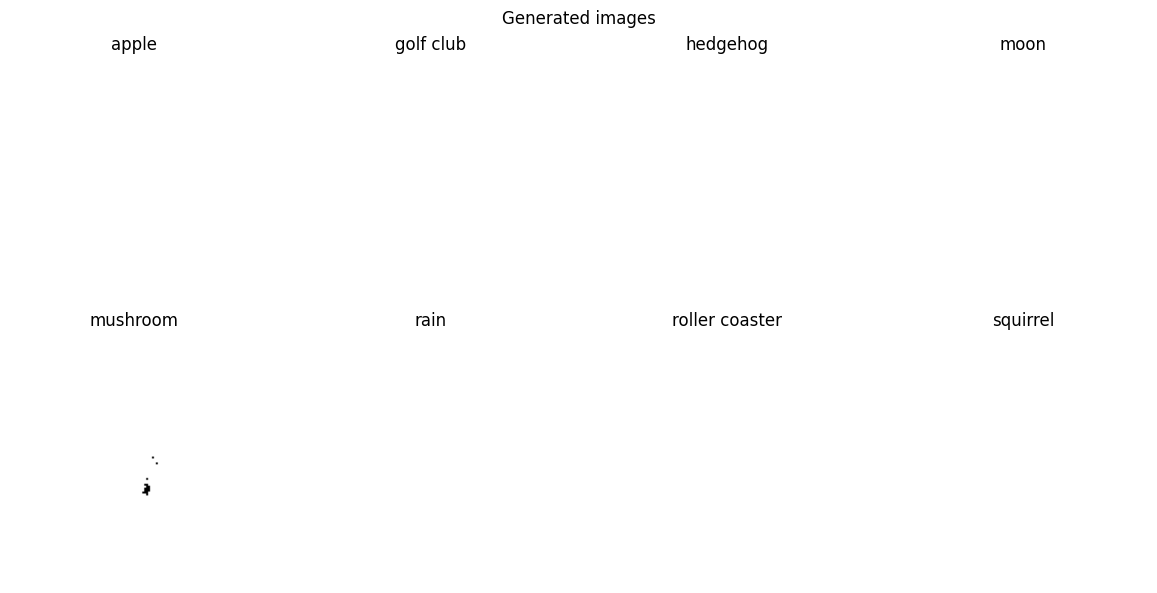

In [32]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)